# SCC.413 Applied Data Mining


## Contents
* [Introduction](#intro)
* [Preamble](#preamble)
* [Pre-processing and cleaning the data](#preprocess)
    - [Cleaning columns](#cleancol)
    - [Cleaning rows](#cleanrow)
    - [Removing stop words](#removestop)
    - [Removing special characters](#removespecial)
* [Tokenisation-Lemmatization / Annotation](#token)
* [Features](#features)
    - [Logistic Regression](#logistic)
    - [MultinomialNB](#multinomial)
    - [Random forest](#randomforest)
    - [Support Vector Classifier (SVC)](#svc)    
    - [Combining text and description](#textdesc)    
* [Evaluation](#evaluation)

<a id="intro"></a>
## Introduction

For the final coursework our goal is trying to cover the following research questions:
 - How easily can a Twitter user's gender be predicted?
 - Are there other features that can improve the prediction apart from the tweet?

For this purpose we are going to import the libraries for classification. We will carry out a pre-processing and cleaning of the dataset. Then we are going to tokenising and create our own bag of words. Extracting features and finally evaluate the how we have approached the research questions.


<a id="preamble"></a>
## Preamble

First, we should import all the libraries needed in one go. Also we need to import the dataset.

In [703]:
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from nltk.stem import PorterStemmer

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

#Import the twitter dataset
dataset = pd.read_csv("gender-classifier-DFE-791531.csv", encoding='latin1')
dataset.head()

#I have change the column 'gender:confidence' to 'gender_confidence' because the concat function below requieres

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender_confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,41406.075,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,658730000000000000,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,40918.5770833333,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,658730000000000000,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,658730000000000000,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,40123.94375,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,658730000000000000,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,658730000000000000,NaN,NaN


<a id="preprocess"></a>
## Pre-processing and cleaning the data

<a id="cleancol"></a>
### Cleaning columns

The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.

We are going to reduce the number of columns because a lot of features are not necessary for our classification and analysis. The following features could be useful for my gender classification:

- gender: one of male, female, or brand (for non-human profiles)
- gender_confidence: a float representing confidence in the provided gender
- description: the user's profile description
- name: the user's name
- text: text of a random one of the user's tweets

In [704]:
#Maintain only the necessary columns/features
dataset = pd.concat([dataset.gender, dataset.gender_confidence, dataset.description,dataset.name,dataset.text],axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 5 columns):
gender               19953 non-null object
gender_confidence    20024 non-null float64
description          16306 non-null object
name                 20050 non-null object
text                 20050 non-null object
dtypes: float64(1), object(4)
memory usage: 783.3+ KB


<a id="cleanrow"></a>
### Cleaning rows

In [705]:
#We are going to clean the rows where the gender is unkown
print('Data before cleaning')
print(dataset['gender'].value_counts())

unknown_data = dataset[dataset['gender'] == 'unknown'].index
dataset.drop(index = unknown_data, inplace = True)
missing_gender = dataset[dataset['gender'].isnull()].index
dataset.drop(index = missing_gender, inplace = True)

#We can delete 1117+empty rows in the dataset
dataset['gender'].value_counts()

Data before cleaning
female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64


female    6700
male      6194
brand     5942
Name: gender, dtype: int64

In [706]:
#We are going to clean the rows where the gender confidence is low
#I set every data under 85% of confidence as lower percentage that we can delete
print('(Lower confidence data) / (Total data) ->', 
      dataset[dataset['gender_confidence'] < 0.85].shape, '/', dataset.shape)

lowConfidence_data = dataset[dataset['gender_confidence'] < 0.85].index
dataset.drop(index = lowConfidence_data, inplace = True)
#We can see the count of rows with confidence higher than 0.85
dataset['gender_confidence'].value_counts()

(Lower confidence data) / (Total data) -> (5024, 5) / (18836, 5)


1.0000    13804
0.9622        2
0.9612        1
0.8503        1
0.9613        1
0.8796        1
0.9636        1
0.9618        1
Name: gender_confidence, dtype: int64

In [707]:
#Now we can delete the confidence column
dataset.drop (columns = ['gender_confidence'], inplace = True)

In [708]:
#We clean every tweet created by a user without description in their profile
print('Data before cleaning: ', dataset['description'].size)

missing_data = dataset[dataset['description'].isnull()].index
dataset.drop(index = missing_data, inplace = True)

#As we can see now we have from 13812 to 11781
dataset['description'].size

Data before cleaning:  13812


11781

<a id="removestop"></a>
### Removing stop words

In [709]:
#The most common words are usually useless for our classification.
#These words are stop words and we can remove them for our analysis

#The most common words from the tweet text
tweet_list = Counter()
for tweet in dataset['text']:
    for word in tweet.split(' '):
        tweet_list[word] += 1

print('The most common words from the tweet text')
print(tweet_list.most_common(10))
print()
        
#The most common words from the user description
desc_list = Counter()
for desc in dataset['description']:
    for word in desc.split(' '):
        desc_list[word] += 1

print('The most common words from the description')        
print(desc_list.most_common(10))

The most common words from the tweet text
[('the', 7505), ('', 7412), ('and', 7070), ('to', 3761), ('I', 2959), ('a', 2767), ('of', 2472), ('in', 2036), ('for', 1974), ('you', 1951)]

The most common words from the description
[('', 3995), ('and', 3897), ('the', 3105), ('of', 2550), ('to', 2188), ('a', 2159), ('I', 1713), ('for', 1690), ('in', 1618), ('&', 1570)]


In [710]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cgrss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [711]:
from nltk.corpus import stopwords
stop_list = stopwords.words('english')

#Save a  new tweet list with any word that is considered as stop word
tweets_with_stop = Counter()
for word, count in tweet_list.items():
    if word in stop_list:
        tweets_with_stop[word] = count

commonT_words = [word for word,cnt in tweets_with_stop.most_common(10)]
print('The most common stop words from the tweet text are: ')
print(commonT_words)
print()

#Save a  new description list with any word that is considered as stop word
desc_with_stop = Counter()
for word, count in desc_list.items():
    if word in stop_list:
        desc_with_stop[word] = count

commonD_words = [word for word,cnt in desc_with_stop.most_common(10)]
print('The most common stop words from the description are: ')     
print(commonD_words)

The most common stop words from the tweet text are: 
['the', 'and', 'to', 'a', 'of', 'in', 'for', 'you', 'is', 'on']

The most common stop words from the description are: 
['and', 'the', 'of', 'to', 'a', 'for', 'in', 'is', 'my', 'you']


<a id="removespecial"></a>
### Removing special characters

In [712]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
emoji_re = re.compile(r":\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    #Depending on the case is better preprocess the emoticons or not
    p_text = emoji_re.sub("[emoticon]",p_text)
    p_text = ftfy.fix_text(p_text)    
    return p_text.lower()

dataset['text_no_special'] = [preprocess(tweet) for tweet in dataset['text']]
dataset['desc_no_special'] = [preprocess(desc) for desc in dataset['description']]
    
dataset.head()

,gender,description,name,text,text_no_special,desc_no_special
0,male,i sing my own rhythm.,sheezy0,Robbie E Responds To Critics After Win Against...,robbie e responds to critics after win against...,i sing my own rhythm.
1,male,I'm the author of novels filled with family dr...,DavdBurnett,ÛÏIt felt like they were my friends and I was...,ûïit felt like they were my friends and i was...,i'm the author of novels filled with family dr...
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",douggarland,Hi @JordanSpieth - Looking at the url - do you...,hi [mention] - looking at the url - do you use...,"mobile guy. 49ers, shazam, google, kleiner pe..."
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,WilfordGemma,Watching Neighbours on Sky+ catching up with t...,watching neighbours on sky+ catching up with t...,ricky wilson the best frontman/kaiser chiefs t...
5,female,you don't know me.,monroevicious,"Ive seen people on the train with lamps, chair...","ive seen people on the train with lamps, chair...",you don't know me.


<a id="token"></a>
## Tokenisation-Lemmatization / Annotation

In [713]:
porter = PorterStemmer()

tokens_fql = Counter()
tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)

def tokenise(text):    
    tokens = tokenise_re.findall(text)
    tokens = [porter.stem(word) for word in tokens]
    
    #This code is in comment because after try to use it,
    #I have noticed that the accuracy is lower using POS tag for adjectives and adverbs
    '''
    pos_tagged  = nltk.pos_tag(tokens)
    newlist = []
    for tag in pos_tagged:
        if tag[1] == ("JJ" or "JJR" or "JJS"):
            newlist.append(tag[1])
        elif tag[1] == ("RB" or "RBR" or "RBS"):
            newlist.append(tag[1])
        else:
            newlist.append(tag[0])
            
    tokens_fql.update(newlist)
    return newlist
    '''
    
    tokens_fql.update(tokens)
    return tokens


dataset['text_token'] = [tokenise(tweet) for tweet in dataset['text_no_special']]

print(tokens_fql)
dataset.head()

Counter({'the': 9156, 'and': 7770, '[url]': 5591, '[mention]': 5446, '.': 5293, '[hashtag]': 4599, 'to': 3926, ',': 3746, 'i': 3435, 'a': 3052, 'of': 2641, 'you': 2406, 'in': 2237, 'for': 2096, 'is': 1853, ':': 1794, '!': 1628, 'on': 1567, 'it': 1550, 'my': 1447, '÷': 1356, '"': 1120, 'with': 1119, 'me': 1110, '...': 1109, 'that': 1107, 'be': 1052, '_ù': 999, '‰': 997, 'have': 954, '=': 952, 'at': 931, 'thi': 931, '?': 928, 'your': 865, 'get': 857, 'are': 830, 'just': 823, 'so': 766, 'all': 731, '-': 695, 'wa': 667, 'like': 663, 'out': 653, "i'm": 638, 'not': 634, 'but': 618, 'up': 606, 'we': 591, 'from': 575, 'do': 564, 'one': 552, 'go': 548, 'if': 502, 'û_': 500, 'love': 493, 'when': 492, 'by': 491, 'can': 482, 'day': 468, 'time': 463, 'about': 461, "it'": 455, 'they': 445, 'what': 440, 'new': 430, 'will': 428, '(': 422, 'now': 417, 'how': 415, 'make': 409, '_': 398, "don't": 395, 'as': 390, 'he': 390, '&': 383, 'look': 375, '\x8f': 371, 'see': 362, 'no': 357, 'peopl': 352, 'know': 3

,gender,description,name,text,text_no_special,desc_no_special,text_token
0,male,i sing my own rhythm.,sheezy0,Robbie E Responds To Critics After Win Against...,robbie e responds to critics after win against...,i sing my own rhythm.,"[robbi, e, respond, to, critic, after, win, ag..."
1,male,I'm the author of novels filled with family dr...,DavdBurnett,ÛÏIt felt like they were my friends and I was...,ûïit felt like they were my friends and i was...,i'm the author of novels filled with family dr...,"[, ûïit, felt, like, they, were, my, friend, ..."
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",douggarland,Hi @JordanSpieth - Looking at the url - do you...,hi [mention] - looking at the url - do you use...,"mobile guy. 49ers, shazam, google, kleiner pe...","[hi, [mention], -, look, at, the, url, -, do, ..."
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,WilfordGemma,Watching Neighbours on Sky+ catching up with t...,watching neighbours on sky+ catching up with t...,ricky wilson the best frontman/kaiser chiefs t...,"[watch, neighbour, on, sky, +, catch, up, with..."
5,female,you don't know me.,monroevicious,"Ive seen people on the train with lamps, chair...","ive seen people on the train with lamps, chair...",you don't know me.,"[ive, seen, peopl, on, the, train, with, lamp,..."


In [714]:
##Get the emoticons 
#We have replace them in the previous step but get an extra list could be used in the future
#However, not all the cases is good practice using this
emoji_fql = Counter()
r = r":\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)"
EMOJI_PATTERN = re.compile(r)
def emoji(text):
    emojis = EMOJI_PATTERN.findall(text)
    emoji_fql.update(emojis)
    return emojis

dataset['text_emoji'] = [emoji(tweet) for tweet in dataset['text']]

print(emoji_fql)
dataset.head()

Counter({':)': 97, ':-)': 27, ':(': 22, ':D': 17, '8-': 10, ':P': 5, ':-(': 5, ':@': 1})


,gender,description,name,text,text_no_special,desc_no_special,text_token,text_emoji
0,male,i sing my own rhythm.,sheezy0,Robbie E Responds To Critics After Win Against...,robbie e responds to critics after win against...,i sing my own rhythm.,"[robbi, e, respond, to, critic, after, win, ag...",[]
1,male,I'm the author of novels filled with family dr...,DavdBurnett,ÛÏIt felt like they were my friends and I was...,ûïit felt like they were my friends and i was...,i'm the author of novels filled with family dr...,"[, ûïit, felt, like, they, were, my, friend, ...",[]
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",douggarland,Hi @JordanSpieth - Looking at the url - do you...,hi [mention] - looking at the url - do you use...,"mobile guy. 49ers, shazam, google, kleiner pe...","[hi, [mention], -, look, at, the, url, -, do, ...",[]
4,female,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,WilfordGemma,Watching Neighbours on Sky+ catching up with t...,watching neighbours on sky+ catching up with t...,ricky wilson the best frontman/kaiser chiefs t...,"[watch, neighbour, on, sky, +, catch, up, with...",[]
5,female,you don't know me.,monroevicious,"Ive seen people on the train with lamps, chair...","ive seen people on the train with lamps, chair...",you don't know me.,"[ive, seen, peopl, on, the, train, with, lamp,...",[]


In [715]:
##Get the adjectives and adverbs lists, however, in the final version I decide to not implement it due to a lower accuracy
adj_fql = Counter()
adv_fql = Counter()
pos_tagged = nltk.pos_tag(tokens_fql)
print(pos_tagged)
print()

adj_list = []
adv_list = []
for tag in pos_tagged:
    if tag[1] == ("JJ" or "JJR" or "JJS"):
        adj_list.append(tag[0])
    elif tag[1] == ("RB" or "RBR" or "RBS"):
        adv_list.append(tag[0])
        
adj_fql.update(adj_list)
adv_fql.update(adv_list)
print(adj_fql)
print(adv_fql)

[('robbi', 'NN'), ('e', 'VBZ'), ('respond', 'NN'), ('to', 'TO'), ('critic', 'VB'), ('after', 'IN'), ('win', 'NN'), ('against', 'IN'), ('eddi', 'JJ'), ('edward', 'NN'), ('in', 'IN'), ('the', 'DT'), ('[hashtag]', 'NNP'), ('[url]', 'NNP'), ('\x89', 'NNP'), ('ûïit', 'NNP'), ('felt', 'VBD'), ('like', 'IN'), ('they', 'PRP'), ('were', 'VBD'), ('my', 'PRP$'), ('friend', 'NN'), ('and', 'CC'), ('i', 'JJ'), ('wa', 'VBP'), ('live', 'JJ'), ('stori', 'NN'), ('with', 'IN'), ('them', 'PRP'), ('û', 'VBP'), ('\x9d', 'JJ'), ('hi', 'NN'), ('[mention]', 'NNP'), ('-', ':'), ('look', 'NN'), ('at', 'IN'), ('url', 'JJ'), ('do', 'VBP'), ('you', 'PRP'), ('use', 'VB'), ('?!', 'JJ'), ("don't", 'NN'), ('typic', 'NN'), ('see', 'VBP'), ('an', 'DT'), ('advanc', 'NN'), ('user', 'NN'), ('on', 'IN'), ('!', '.'), ('watch', 'VB'), ('neighbour', 'JJ'), ('sky', 'NN'), ('+', 'NN'), ('catch', 'VBP'), ('up', 'RP'), ('neighb', 'JJ'), ('!!', 'NNP'), ('xxx', 'NNP'), ('_ù', 'NNP'), ('÷', 'NNP'), ('ä_ù', 'NNP'), ('ä_ùôî_ù', 'NNP'), 

<a id="features"></a>
## Features

A couple of methods for showing classifier results (from 1st classification lab):

In [716]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

We are going to perform the usual train/test split by employing different classification models.

In [717]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['gender'].astype(str))
X = dataset['text']

#split the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

8246 3535
8246 3535


TF-IDF is a commonly used normalisation method which considers the term frequency along with how many documents in the corpus the term appears in. In our TF-IDF I use the stop word list that was previously created, the preprocess and tokenise methods. And also the emoji and adjectives frequent list. We can observe that logistic regression and SVC have a better result if we use ngram and multinominalNB and random forest have a worse result.

<a id="logistic"></a>
### Logistic Regression

Accuracy:  0.5886845827439887
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       903
           1       0.61      0.62      0.61      1386
           2       0.52      0.44      0.48      1246

    accuracy                           0.59      3535
   macro avg       0.59      0.60      0.59      3535
weighted avg       0.58      0.59      0.58      3535

[[669  79 155]
 [166 859 361]
 [214 479 553]]


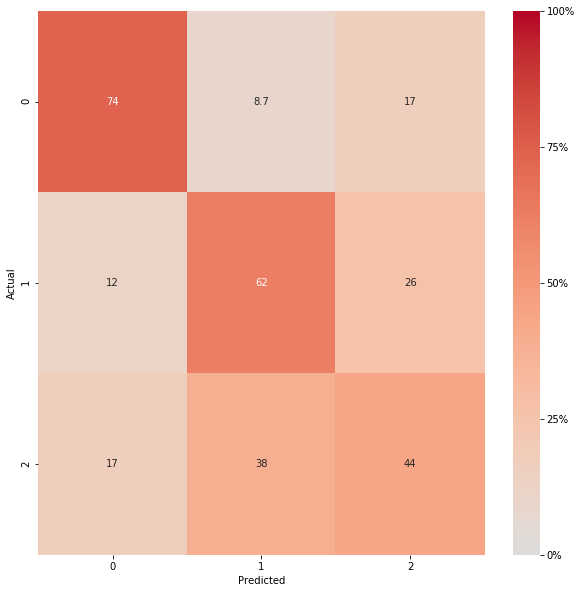

In [718]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,                                                
                        tokenizer=tokenise,
                        ngram_range=(1,2)
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr'))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), clf.classes_)

<a id="multinomial"></a>
### MultinomialNB

Accuracy:  0.5425742574257426
              precision    recall  f1-score   support

           0       0.71      0.40      0.51       903
           1       0.52      0.79      0.63      1386
           2       0.50      0.37      0.42      1246

    accuracy                           0.54      3535
   macro avg       0.58      0.52      0.52      3535
weighted avg       0.56      0.54      0.53      3535

[[ 360  306  237]
 [  59 1100  227]
 [  86  702  458]]


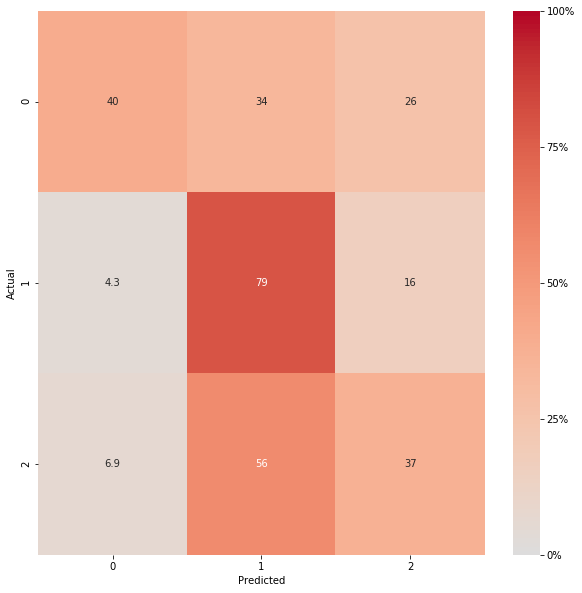

In [719]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise,                        
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', MultinomialNB())])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), clf.classes_)

<a id="randomforest"></a>
### Random Forest

Accuracy:  0.5702970297029702
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       903
           1       0.56      0.65      0.60      1386
           2       0.51      0.40      0.45      1246

    accuracy                           0.57      3535
   macro avg       0.57      0.58      0.57      3535
weighted avg       0.57      0.57      0.56      3535

[[615 129 159]
 [161 899 326]
 [180 564 502]]


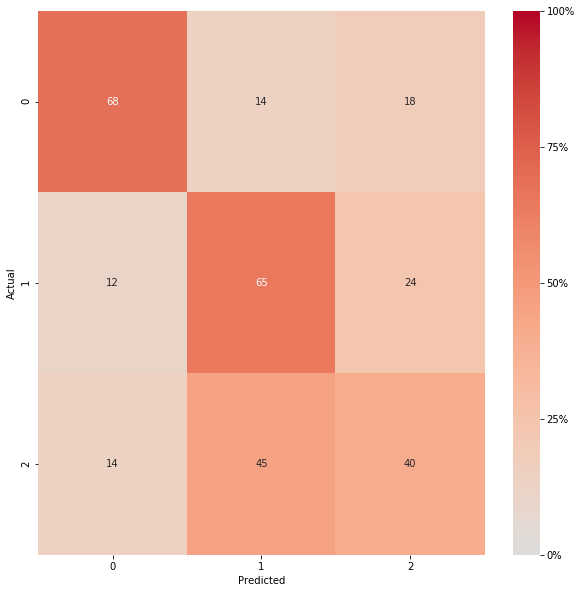

In [720]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 40, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), clf.classes_)

<a id="svc"></a>
### Support Vector Classifier (SVC)

Accuracy:  0.5917963224893918
              precision    recall  f1-score   support

           0       0.64      0.76      0.69       903
           1       0.61      0.60      0.60      1386
           2       0.52      0.47      0.49      1246

    accuracy                           0.59      3535
   macro avg       0.59      0.61      0.60      3535
weighted avg       0.59      0.59      0.59      3535

[[686  79 138]
 [173 826 387]
 [218 448 580]]


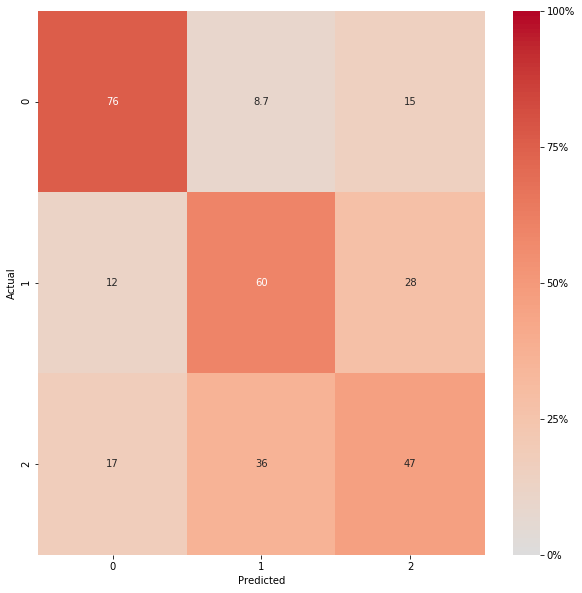

In [721]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise,                        
                        ngram_range=(1,2)
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), clf.classes_)

- Logistic regression accuracy:  0.5886845827439887
- MultinomialNB accuracy: 0.5425742574257426
- Random forest acuuracy: 0.5702970297029702
- SVC accuracy: 0.5917963224893918

<a id="textdesc"></a>
### Combining text and description

In [654]:
#Fill NaN with empty string
dataset.fillna("", inplace = True)

#Concatenate text with description thanks to the Series helper functions Series.str()
dataset['text_description'] = dataset['text'].str.cat(dataset['description'], sep=' ')

In [655]:
#Split the dataset in train and test
X2 = dataset['text_description']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=0, stratify=y)

X_train2.head()
X_train2.isnull().values.any() #Make sure that there is not empty value

False

Accuracy:  0.6777934936350778
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       903
           1       0.67      0.71      0.69      1386
           2       0.63      0.54      0.58      1246

    accuracy                           0.68      3535
   macro avg       0.68      0.69      0.68      3535
weighted avg       0.67      0.68      0.67      3535

[[738  65 100]
 [106 980 300]
 [142 426 678]]


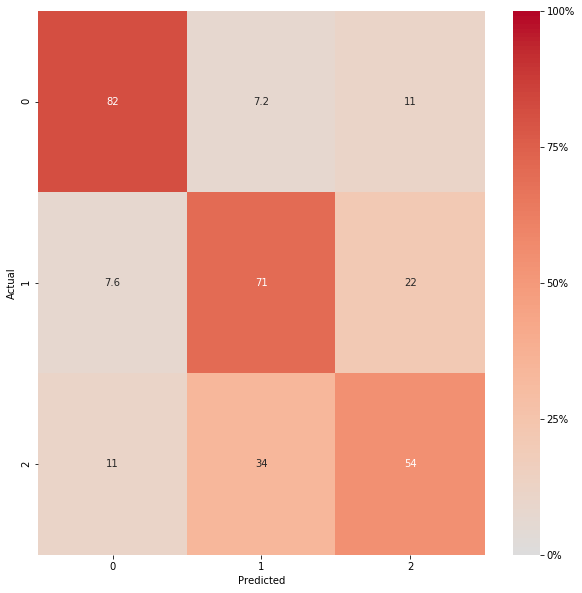

In [656]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,                                                
                        tokenizer=tokenise
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr'))])

clf.fit(X_train2, y_train2)

predictions = clf.predict(X_test2)
print("Accuracy: ", accuracy_score(y_test2, predictions))
print(classification_report(y_test2, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test2,predictions), clf.classes_)

Accuracy:  0.6480905233380481
              precision    recall  f1-score   support

           0       0.90      0.61      0.72       903
           1       0.59      0.86      0.70      1386
           2       0.62      0.44      0.52      1246

    accuracy                           0.65      3535
   macro avg       0.70      0.64      0.65      3535
weighted avg       0.68      0.65      0.64      3535

[[ 547  183  173]
 [  22 1191  173]
 [  38  655  553]]


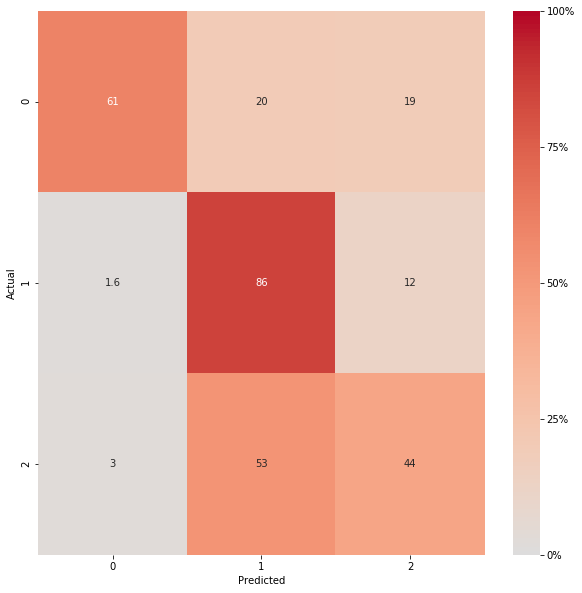

In [657]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise,                        
                        ngram_range=(1,2)
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', MultinomialNB())])
clf.fit(X_train2, y_train2)

predictions = clf.predict(X_test2)
print("Accuracy: ", accuracy_score(y_test2, predictions))
print(classification_report(y_test2, predictions))
print(confusion_matrix(y_test2, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test2,predictions), clf.classes_)

Accuracy:  0.6531824611032532
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       903
           1       0.62      0.75      0.68      1386
           2       0.60      0.45      0.52      1246

    accuracy                           0.65      3535
   macro avg       0.66      0.66      0.66      3535
weighted avg       0.65      0.65      0.65      3535

[[ 703   86  114]
 [  84 1040  262]
 [ 126  554  566]]


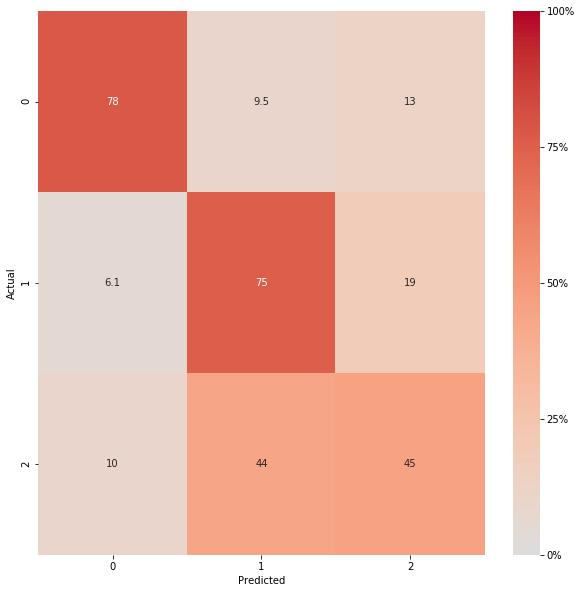

In [658]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise                        
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 40, random_state=0))])

clf.fit(X_train2, y_train2)

predictions = clf.predict(X_test2)
print("Accuracy: ", accuracy_score(y_test2, predictions))
print(classification_report(y_test2, predictions))
print(confusion_matrix(y_test2, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test2,predictions), clf.classes_)

Accuracy:  0.6857142857142857
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       903
           1       0.69      0.68      0.68      1386
           2       0.63      0.57      0.60      1246

    accuracy                           0.69      3535
   macro avg       0.69      0.70      0.69      3535
weighted avg       0.68      0.69      0.68      3535

[[764  44  95]
 [108 945 333]
 [141 390 715]]


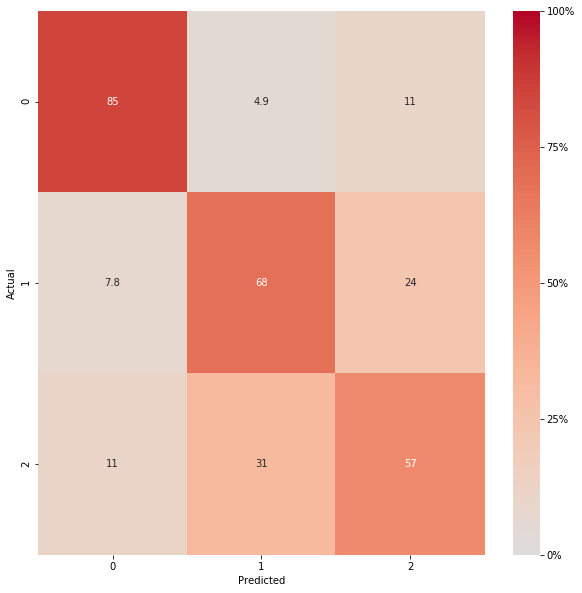

In [660]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise,                        
                        ngram_range=(1,2)
                        )
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train2, y_train2)

predictions = clf.predict(X_test2)
print("Accuracy: ", accuracy_score(y_test2, predictions))
print(classification_report(y_test2, predictions))
print(confusion_matrix(y_test2, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test2,predictions), clf.classes_)

- Logistic regression accuracy:  0.6777934936350778
- MultinomialNB accuracy: 0.6480905233380481
- Random forest acuuracy: 0.6531824611032532
- SVC accuracy: 0.6857142857142857

<a id="evaluation"></a>
## Evaluation

As we can observe from the previous section, SVC classifier obtained the best result if we only consider the text of the tweet. However, the accuracy in neither case exceed 60%. 
If we merge the description of the user with the text we can see a significant improvement and also the SVC classifier obtained the best result. An important fact is that in both SVC we see improvement by using ngrams.
Finally, if we combine all of them by using VotingClassifier we can obtain the best result possible.

Accuracy:  0.6916548797736917
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       903
           1       0.66      0.75      0.70      1386
           2       0.65      0.53      0.58      1246

    accuracy                           0.69      3535
   macro avg       0.70      0.70      0.70      3535
weighted avg       0.69      0.69      0.69      3535

[[ 749   61   93]
 [  90 1040  256]
 [ 117  473  656]]


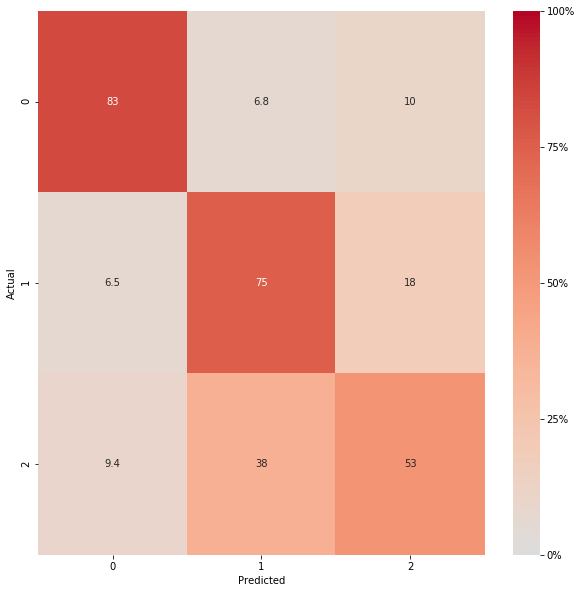

In [702]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=commonT_words,
                        preprocessor=preprocess,
                        tokenizer=tokenise,                        
                        ngram_range=(1,2)
                        )

clf1 = LogisticRegression(multi_class='ovr', random_state=0)
clf2 = MultinomialNB()
clf3 = RandomForestClassifier(n_estimators = 80, random_state=0)
clf4 = SVC(kernel = 'linear',probability = True, random_state=0)

ensemble_clf = VotingClassifier(estimators=[
        ('lr', clf1), ('mn', clf2), ('rf', clf3), ('svc', clf4)], voting='soft')

clf = Pipeline([('vect', tfidf),
                ('clf', ensemble_clf)])

clf.fit(X_train2, y_train2)

predictions = clf.predict(X_test2)
print("Accuracy: ", accuracy_score(y_test2, predictions))
print(classification_report(y_test2, predictions))
print(confusion_matrix(y_test2, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test2,predictions), clf.classes_)

The increase of accuracy obtained by combining all the classifiers is not very significant. 0.685 - 0.691
This is our best result. As we can see is a combination of stop_wordp,preprocess,tokenizer and ngram_range=(1,2).



In [602]:
'''
from sklearn.feature_extraction.text import CountVectorizer
def get_emoji_fql():    
    return emoji_fql


def get_adj_fql():    
    return adj_fql


model = Pipeline([
    ('selector', SelectKBest(score_func = chi2)),
    ('clf', None) #clf set in param_grid.
])

search = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score=False, 
                      scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid={
                          'union__word__processor__process_method': [get_emoji_fql, get_adj_fql],
                          'selector__k': [50, 150, 400, 750],
                          'clf': [LogisticRegression(multi_class='ovr', random_state=0),
                                  MultinomialNB(),RandomForestClassifier(n_estimators = 80, random_state=0),
                                 SVC(kernel = 'linear',probability = True, random_state=0)]
                      })
search.fit(X_train2, y_train2)

predictions = search.predict(X_test2)

print("Accuracy: ", accuracy_score(y_test2, predictions))
print(classification_report(y_test2, predictions))
print(confusion_matrix(y_test2, predictions))

confusion_matrix_heatmap(confusion_matrix(y_test2,predictions), search.classes_)
'''

'\nfrom sklearn.feature_extraction.text import CountVectorizer\ndef get_emoji_fql():    \n    return emoji_fql\n\n\ndef get_adj_fql():    \n    return adj_fql\n\n\nmodel = Pipeline([\n    (\'selector\', SelectKBest(score_func = chi2)),\n    (\'clf\', None) #clf set in param_grid.\n])\n\nsearch = GridSearchCV(model, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), \n                      return_train_score=False, \n                      scoring=[\'accuracy\', \'precision_weighted\', \'recall_weighted\', \'f1_weighted\'],\n                      refit = \'f1_weighted\',\n                      param_grid={\n                          \'union__word__processor__process_method\': [get_emoji_fql, get_adj_fql],\n                          \'selector__k\': [50, 150, 400, 750],\n                          \'clf\': [LogisticRegression(multi_class=\'ovr\', random_state=0),\n                                  MultinomialNB(),RandomForestClassifier(n_estimators = 80, random_state=0),\n      